In this file, we present a sample code for using particle filter to predict the reamining useful life of a fatigue crack propogation process. The physical model for the crack growth process is the Paris model. The code is from the turorial of Matteo Corbetta, Introduction to Prognosis, Tutorial at PHM2019: https://phmsociety.org/wp-content/uploads/2021/04/TutorialPrognostics2019.zip.

# Physics-based model
The model underneath PF is the well-known Paris' law equation for FCG in the log-linear regime, using an analytical stress intensity factor formulation for infinite plate:

$\frac{da}{dN} = C(\Delta K)^m,$

where
* $a$ is the crack length,
* $N$ is the testing time (in cycles),
* $C$ and $m$ are two parameters that depend on material properties, that need to be determined based on experience or historical data,
* $\Delta K$ is stress intensity factor, and is defined as:

$\Delta K = f\Delta \sigma \sqrt{\pi a},$

where 
* $f$ is called crack shape function and depends on the shape of the specimen;
* $\Delta \sigma$ is the applied stress range.

Please note that the crack initiates at a rivet notch, therefore the crack shape function F should be modified to account for the stress concentration at the notch. However, the script fix F equal to 1 and let PF adjusts the prediction.


In [1]:
import numpy as np

# If using Python < 3, you need to add Agg rendering for matplotlib. otherwise, the script will raise an error about Python not installed as a framework.
# import matplotlib as mpl
# mpl.use('TkAgg')

import matplotlib.pyplot as plt

# --------------------------------------------------------------
# CRACK PROPAGATION FUNCTIONS
# --------------------------------------------------------------
def sif(cl, stressRange, crackShapeFun):
    """
    Call:
        DK = sif(cl, stressRange, crackShapeFun)

    Description:
    Analytical solution of the stress intensity factor (SIF) range in case of infinite plate with semi crack length cl subject to a far field tensile stress with amplitude stressRange.
    The crack shape function defines the intensification factor due to geometric variations. A crackShapeFun = 1.0 defines a crack in the middle of the plate, while a crackShapeFun ~ 1.12 defines a crack on the edge of the plate (the plate is considered infinite in all other directions from the edge). Those values are simplified values and complex structures have different values for crackShapeFun and SIF.
    This formulation assumes a crack opening in mode I (tensile mode).

    :param: cl:                             semi-crack length, [mm]
    :param: stressRange:                    applied stress range, [MPa]
    :param: crackShapeFun:                  crack shape function to define intensification due to geometry, [-]
    :return SIF:                            stress intensity factor [MPa \sqrt(mm)]
    """
    return crackShapeFun * stressRange * np.sqrt(np.pi * cl)

def ParisLaw(DK, C, m):
    """
    Call:
        dadn = ParisLaw(DK, C, m)

    Description:
    Paris' law to compute the fatigue crack growth rate dadn given the range of the stress intensity factor DK and the two empirical parameters C and m.

    Simplifying hypothesis:
        - effects of variable-amplitude and average stress are ignored, assumed to be embedded into parameter C
        - slow crack growth in the threshold region ignored
        - accelerated crack growth in the unstable region ignored

    :param: DK:         stress intensity factor range, [MPa \sqrt(mm)]
    :param: C:          intercept of Paris' law [mm/cycle * 1/(MPa \sqrt(mm))^(m)]
    :param: m:          slope of Paris' law, [-]
    :return C*DK^m      crack growth rate according to the Paris' law model [mm/cycle]
    """
    return C * DK**m

# The particle filter model
## The process model
Read the code, and try to answer the following questions:
* What are the state variables?
* How was the process noise modeled?
* How was the inital particles being generated?


In [2]:
def stateTransition(state, input, theta, noiseVars, dt):
    """
    Call:
            state = stateTransition(state, input, theta, noiseVars, dt)

    Description:
    This function perform the state transition from time step k-1 to time step k using the state equation

                    \dot{x} = f_{\theta}(x, u, \epsilon)

    and then updating the state in a typical forward Euler's integration:

                    x_{k} = x_{k-1} + f_{\theta}(x, u, \epsilon) * dt_{k-1}

    where:
        x is the state vector (augmented-state vector if model parameters are estimated during run)
        \theta is the vector of model parameters
        u is the input vector
        \epsilon is the model perturbation (or process noise)
        dt is the time step size

    In this application, the model f() and the corresponding equations are explicitly translated into the crack propagation model.

    x = [crackLength, logC, m]
    u = stressAmplitude
    \theta = crackShapeFun
    \epsilon = noiseVars = [stateNoiseVar, logCNoiseVar, mNoiseVar] (NB: the model noises are defined only by their variances in this case)
    (dt is self-explanatory)

    :param: state:      state vector, n x p, where n is number of samples and p is number of dimensions
    :param: input:      input vector, scalar
    :param: theta:      model parameter vector (only the ones not included in the state vector), 1 x 1
    :param: noiseVars:  noise variances for the state equation, 3 x 1
    :return: state:     updated state vector
    """

    # -------- Extract elements from each function input -------- #
    # extract state variables
    nsamples, nstates = state.shape

    crack = state[:, 0].reshape((nsamples,))
    logC  = state[:, 1].reshape((nsamples,))
    m     = state[:, 2].reshape((nsamples,))

    # constant model parameters and input
    crackShapeFun   = theta
    stressAmplitude = input

    # variance of model noise for state transition
    stateNoiseVar, logCNoiseVar, mNoiseVar = noiseVars

    # -------- Compute state transition ---------- #
    crack = crack + ParisLaw(sif(crack, stressAmplitude, crackShapeFun), np.exp(logC), m) * \
                    np.exp( - stateNoiseVar/2.0 + np.sqrt(stateNoiseVar) * np.random.randn(nsamples) ) * dt

    state[:, 0] = crack
    return state

def observationLikelihood(state, measure, noiseVar):
    """
    Likelihood of the observed value (measure) given the current state (state).
    This funciton uses a Gaussian likelihood, but infinite options are available.

    :param: state:          scalar, state value
    :param: measure:        scalar, measure value
    :return likelihood of the measure given the state, l(measure | state)
    """
    return 1.0 / (np.sqrt(2 * np.pi * noiseVar)) * np.exp( -0.5 * (measure - state)**2.0 / noiseVar )

## The observation model

The observation equation is given by:

$z_k = x_k + \epsilon$ where 

$\epsilon$ is a normal distribution with zeor mean.

No information on the measurement system is provided. The crack length measures from the FCG dataset are assumed to be the "true" crack lengths.
To better understand what PF does, the true crack lengths are not provided to the algorithm, but a random sample from a Gaussian distribution centered at the true crack length is fed as measure.
By so doing, the user can appreciate the filtering capabilities of the method.

The measures generated by the Gaussian pdfs are "artifacts". In real applications, the user should be able to quantify the error of the measurement system and use that to construct the likelihood of the
observations given the sample, i.e., l(z_k|x_k^i), where z_k is the measure at k time step, x_k^i is the i-th sample value of the crack length at k time step.


In [3]:
# --------------------------------------------------------------
# MEASUREMENT SYSTEM FUNCTIONS
# --------------------------------------------------------------

def measurementSystem(trueVal, noiseVar):
    """
    Synthetic measurement system, Gaussian and unbiased.
    The function generates a "synthetic measure", starting from the (supposed true) value, and adding a perturbation
    with variance noiseVar (input to the function).

    :param: trueVal:        scalar, true value of the system, supposed unknown
    :param: noiseVar:       scalar, variance describing measurement system (supposed Gaussian)
    :return measure sample from Gaussian distribution N(trueVal, noiseVar)
    """
    return  trueVal + np.sqrt(noiseVar) * np.random.randn()

## Particle filtering supporting codes

In [4]:
# --------------------------------------------------------------
# PARTICLE FILTER FUNCTIONS
# --------------------------------------------------------------
def systematicResampling(state, weights):
    """
    Resampling of state variables with the law:

    Pr{x^j = x^i} = w^i

    The function returns the new samples of the state and their corresponding weight.
    Although the new weights are all identical (1/nsamples) if using systematic resampling, the function can be
    modified to compute different resampling strategies with different output weights.

    :param: state:          nsamples x nstates array, samples of the state vector
    :param: weights:        nsamples x 1 array, weights of each state sample
    :return: newState:      nsamples x nstates array, new set of samples according to systematic resampling
    :return: newWeights:    nsamples x 1 array, weights of the new set of samples of the state vector.
    """
    nsamples, nstates = state.shape
    X = np.zeros((nsamples, nstates+2))

    X[:, 0:nstates] = state
    X[:, nstates] = weights
    X[:, nstates+1] = np.cumsum(X[:, nstates])

    newState = np.zeros((nsamples, nstates))
    for ii in range(nsamples):
        r = np.random.rand()
        if r >= np.max(X[:, -1]):
            idx = nsamples-1
        elif r <= np.min(X[:, -1]):
            idx = 1
        else:
            idx = np.argmin(abs(X[:, -1] - r))
        newState[ii, :] = X[idx, :-2]

    return newState, np.ones((nsamples,)) / nsamples

def computeConfIntervals(x, pd, alpha, singleSide=False):
    """
    Call:
        lowerBound, upperBound = computeConfIntervals(x, pd, alpha)

    Description:
        Numerical computation of the confidence intervals of a RV "X" with arbitrary probability density function.
        x contains samples of X, while pd is the corresponding probability density of the samples x.
        It can compute both signle-sided or double-sided (symmetric) confidence intervals.

        if singleSide == False
            The confidence interval is symmetric
            alpha \in (0.0, 0.5)
            bounds is a tuple of form ( x*, x** ), such that Pr{X < x*} = alpha/2.0 and Pr{X < x**} = (1-alpha/2.0)

        if singleSide == True
            The confidence interval is not symmetric,
            alpha \in (0.0, 1.0)
            The output "bounds" is a scalar containing the value x* such that Pr{X < x*} = alpha

    :param: x:              samples of the RV X, doubles, (n x 1) array
    :param: pd:             probability density of x, doubles, (n x 1) array
    :param: alpha:          confidence level, double, scalar, within (0, 0.5) range
    :return bounds:         either a tuple (for symmetric confidence intervals) or a scalar (for single-sided confidence intervals)
    """

    X = np.zeros((len(x), 3))
    X[:, 0] = x
    X[:, 1] = pd / np.sum(pd)
    X = X[X[:, 0].argsort()]
    X[:, 2] = np.cumsum(X[:, 1])

    if singleSide:
        idx_bound = np.argmin(abs(X[:, -1] - alpha))
        bounds = X[idx_bound, 0]
    if not singleSide:
        idx_lowerBound = np.argmin(abs(X[:, -1] - alpha/2.0))
        idx_upperBound = np.argmin(abs(X[:, -1] - (1-alpha/2.0)))

        lowerBound = X[idx_lowerBound, 0]
        upperBound = X[idx_upperBound, 0]
        bounds = (lowerBound, upperBound)

    return bounds

def prognoser(state, theta, input, noiseVars, dt, threshold):
    """
    Call:
        ttf_samples = prognoser(state, theta, input, noiseVars, dt, threshold)

    Description:
        This function computes the state hitting time of the threshold, or first hitting time (FHT), given the state vector composed of crack length, logC and m.
        The function uses the stochastic integration of the differential equation:

                            da
                            -- = C (DK)^m e^{\omega}
                            dn

        Instead of using Euler's forward integration, the function uses the separation of variable method for stochastic differential equations.
        The method is hundreds of times faster than traditional Monte Carlo integration.

    where:
        da/dn is the crack growth rate per load cycle
        C, m are the Paris' law empirical parameters
        DK is the stress intensity factor range
        omega ~ N (-sigma^2/2.0, \sigma^2)

    :param: state:          nsamples x nstates array, samples of state vector
    :param: theta:          nparams x 1 array, model parameter
    :param: input:          ninput x 1 array, model input
    :param: noiseVars:      nstates x 1 array, variance of model noise for state transition
    :param: dt:             scalar, integration time step
    :param: threshold:      scalar, limit crack length to calculate FHT
    :return fht_samples:    nsamples x 1 array, samples of FHT based on the defined threshold
    """

    # Extract state variables, parameters and input
    cl, logC, m = state[:, 0], state[:, 1], state[:, 2]
    crackShapeFun = theta
    stressRange   = input

    # extract noise variances to use to propagate the model error (process noise) in time
    v0, v1, v2 = noiseVars

    # compute FHT by integrating Paris law with log-Normal noise e^{\omega}
    fht_samples = np.zeros((nsamples,)) # Initialize FHT samples

    for sample in range(nsamples):
        Cprime = np.exp(logC[sample]) * (crackShapeFun * stressRange * np.pi**(1.0/2.0))**m[sample] # Compute equivalent parameter that does not depend from crack length (i.e., constant)
        mfht = (threshold ** (1 - m[sample]/2.0) - cl[sample]**(1 - m[sample]/2.0)) / ( Cprime * (1 - m[sample]/2.0))   # compute the expected FHT,
        nsteps = int(np.round(mfht / dt) ) # step size of random process
        r = -v0/2.0 + np.sqrt(v0) * np.random.randn(nsteps)
        fht_samples[sample] = np.sum(np.exp(r) * dt)

    return fht_samples

# Main function

**********************************************************************
Percentage RUL error w.r.t. the current true RUL

   Normalized Load Cycles [%]        RUL error [%]
[[ 0.          3.40858156]
 [26.60550459  0.52740718]
 [44.95412844  7.85594532]
 [63.30275229  6.07128361]
 [81.65137615 38.23401794]]
**********************************************************************
**********************************************************************
Absolute error on the end-of-life

   Normalized Load Cycles [%]        EOL error [-]
[[  0.         371.53538983]
 [ 26.60550459  42.19257464]
 [ 44.95412844 471.35671898]
 [ 63.30275229 242.85134432]
 [ 81.65137615 764.68035878]]
**********************************************************************


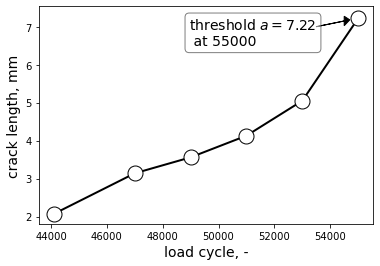

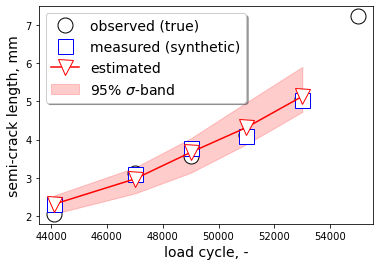

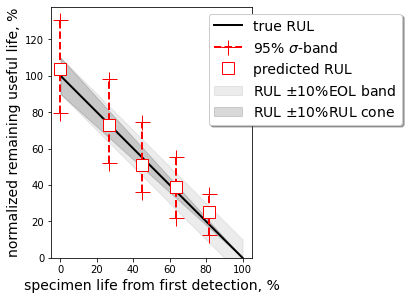

In [5]:
# ---------------------------------------------------------------------------------
# GET OBSERVATION FROM DATASET
# ---------------------------------------------------------------------------------
def getDataPoint(dataSet, idx):
    return dataSet['cracklength'][idx], dataSet['loadCycle'][idx]


if __name__ == '__main__':

    # Fixing random seed for repeatability
    np.random.seed(123456)

    # ------------------------------------------------------------------------------------
    # DEFINE DATASET AND FILTER PARAMETERS PARAMETERS
    # This dataset is small, and using particle filtering to solve the problem is questionable given its limited amount of measures.
    # However, it's a good exercise to practive with particle filtering.
    # ----------------------------------------------------------------------------------------
    # Dataset
    dataSet = {'loadCycle':   np.array([44100, 47000, 49000, 51000, 53000, 55000]),
               'cracklength': np.array([ 2.07,  3.14,  3.56,  4.13,  5.05,  7.22]) }

    # filtering parameters
    dn = 100  # [-], load cycles step size (equivalent to dt, but typically is an integer)
    nsamples = 2000  # [-], number of Monte Carlo samples
    alpha = 0.05  # [-], proportion expressing (1-confidence) on the computed values

    sim_steps = len(dataSet['loadCycle']) - 1   # [-], number of steps of the simulation
    cl_th = dataSet['cracklength'][-1]  # [mm], semi crack length threshold to compute remaining useful life

    # --------------------------------------------------------------------------------
    # DEFINE MODEL PARAMETERS AND INPUT
    # --------------------------------------------------------------------------------
    nstates = 3  # [-], size of state vector (crack length, logC, m)

    # --------------- Input ------------------------- #
    stressRange = 95  # [MPa], applied stress range, measured, assumed deterministic. R \approx 0 even if is slightly larger
    stressRatio = 5.0/100.0      # [-], stress ratio defined by min(stress(t)) / max(stress(t))

    # --------------- Paris' law parameters ------------------------- #
    F = 1.0
    C0 = 2.382e-12 / (1.0 - stressRatio)    # [mm/cycle * 1/(MPa\sqrt(mm)^(m))], initial value of C
    m0 = 3.25                               # [-], initial value of m
    logC0 = np.log(C0)                      # use log(C) for estimation since (log C, m) ~ MVN, and since artificial dynamics does not work with bounded quantities

    # var_logC, var_m, rho_logCm = 0.9966/2.0, 0.0346/2.0, -0.98
    var_logC, var_m, rho_logCm = 0.9966/4.0, 0.0346/4.0, -0.98
    covar_logCm = rho_logCm * np.sqrt(var_logC) * np.sqrt(var_m)

    # Define mean and covariance matrix
    mean_params = np.array([logC0, m0])
    cov_params  = np.array([[var_logC, covar_logCm],
                            [covar_logCm,    var_m]])

    # --------------- Model noise parameters ------------------------- #
    modelVar = [0.01, var_logC, var_m]   # [-], model noise variances
    # --------------- Measurement parameters ------------------------- #
    measureVar = 0.015        # [mm^2], variance of measurement noise

    # --------------------------------------------------------------------------------
    # INITIALIZE FILTER
    # --------------------------------------------------------------------------------

    # ----------------------- initialize state vector -------------------- #
    x = np.zeros((nsamples, nstates))
    xtmp = np.random.multivariate_normal(mean_params, cov_params, nsamples)
    x[:, 1], x[:, 2] = xtmp[:, 0], xtmp[:, 1]# x: the particles
    w = 1.0 / nsamples * np.ones((nsamples,))# w: the weight
    
    # semi-crack length values will be assigned when first measure is collected

    # ----------------------- Allocate memory to plot results -------------------- #
    # mean values
    cl_mean, logC_mean, m_mean = np.zeros(sim_steps), np.zeros(sim_steps), np.zeros(sim_steps)
    rul_mean = np.zeros(sim_steps)
    
    # confidence intervals
    cl_interval  = np.zeros((sim_steps, 2))
    logC_interval = np.zeros((sim_steps, 2))
    m_interval    = np.zeros((sim_steps, 2))
    rul_interval  = np.zeros((sim_steps, 2))

    # measure vector
    measure_vector = np.zeros((sim_steps,))

    # --------------------------------------------------------------------------------
    # RUN PARTICLE FILTER
    # --------------------------------------------------------------------------------
    for k in range(sim_steps):

        # ----------------- Extract measure from data ---------------- #
        observedCrack, current_loadCycle = getDataPoint(dataSet, k)             # extract "true" crack length
        current_measure = measurementSystem(observedCrack, measureVar)          # measure from the true crack length
        measure_vector[k] = current_measure                                     # store measure in measure_vector

        #  ----------------- particle filtering---------------- #
        if k == 0:
            """
            If this is the first measure, there's no filtering. build the samples around 
            the first measure (using the variance of the measurement system to define the dispersion)
            and then perform first prognosis.
            """
            x[:, 0] = current_measure + np.sqrt(measureVar) * np.random.randn(nsamples)
        else:
            """
            FILTERING.
            Since the measures were taken at irregular intervals, the propagation of the samples between those intervals
            is made with a while loop. Within the while loop, the state is propagated with no filtering.
            When the increasing number of load cycle reaches the number of load cycles at which the measure was recorded,
            filtering is performed using the bootstrap particle filtering with systematic resampling.  
            """
            # ------ Propagate sample until the next measure --------- #
            loadCycle_tmp = old_loadCycle
            while loadCycle_tmp < current_loadCycle:
                x = stateTransition(x, stressRange, F, modelVar, dn)
                loadCycle_tmp += dn

            # --------- Artificial dynamics for model parameters --------- #
            """
            Decrease variance of logC, m to ensure better convergence, since initial variance of (log C, m) is large.
            Many other parameter estimation solutions can be adopted to improve convergence, while this one is the simplest.
            The limited number of observations, however, reduces what can be achieved with particle filter at this stage.

            Using kernel smoothing or other mode advanced techniques could help improve convergence.
            Please refer to:
            Liu, J. West, M. Combined parameter and state estimation in simulation-based filtering.
            In Sequential Monte Carlo Method in Practice, Springer, 2001.
            """
            cov_params[0, 0] /= 10.0
            cov_params[1, 1] /= 10.0
            cov_params[0, 1] = rho_logCm * np.sqrt(cov_params[0, 0] * cov_params[1,1]) # re-compute covariance to ensure correlated samples
            cov_params[1, 0] = cov_params[0, 1]
            # resample from multivariate Gaussian
            r = np.random.multivariate_normal(np.zeros((2,)), cov_params, nsamples)

            # Add perturbation term to elements of the augmented state vector (i.e., model parameters)
            x[:, 1] += r[:, 0]
            x[:, 2] += r[:, 1]

            # --------------- weight updating according to bootstrap particle filtering ------------------ #
            l = observationLikelihood(x[:, 0], current_measure, measureVar)
            w = w * l
            w = w /np.sum(w)

            # ---------------- Resampling -------------------------------- #
            x, w = systematicResampling(x, w)
            w = w / np.sum(w)                       # to avoid numerical errors

        """
        Once filtering is completed, perform RUL estimation
        
        """
        rul_samples = prognoser(x, F, stressRange, modelVar, dn, cl_th)

        # --------------- Store results ------------ #
        # Compute mean values of state vector
        cl_mean[k]  = np.sum(x[:, 0] * w) / np.sum(w)
        logC_mean[k] = np.sum(x[:, 1] * w) / np.sum(w)
        m_mean[k]    = np.sum(x[:, 2] * w) / np.sum(w)
        rul_mean[k]  = np.sum(rul_samples * w) / np.sum(w)

        # Compute confidence intervals of the state vector
        cl_interval[k, 0],   cl_interval[k, 1] = computeConfIntervals(x[:, 0], w, alpha)
        logC_interval[k, 0], logC_interval[k, 1] = computeConfIntervals(x[:, 1], w, alpha)
        m_interval[k, 0],       m_interval[k, 1] = computeConfIntervals(x[:, 2], w, alpha)
        rul_interval[k, 0],   rul_interval[k, 1] = computeConfIntervals(rul_samples, w, alpha)

        # --------- Update measure and load cycles for next iteration --------- #
        old_loadCycle = current_loadCycle
        old_measure = current_measure




    # --------------------------------------------------------------------------------
    # POST PROCESSING FOR PLOTTING
    # --------------------------------------------------------------------------------

    # Create normalized vector of load cycles to plot data w.r.t. percentage of component life (0 to 100, where 100 means end of life, EOL)
    normalized_loadCycle_vector = (dataSet['loadCycle'] - dataSet['loadCycle'][0]) / float(dataSet['loadCycle'][-1] - dataSet['loadCycle'][0]) * 100.0

    #  ----------------- Define RULs ------------------------------ #
    predRul      = rul_mean.copy()                                          # [-] get predicted RUL
    intervalRul  = rul_interval.copy()                                      # [-]
    trueRul      = abs(dataSet['loadCycle'] - dataSet['loadCycle'][-1])

    # ------------------ Define EOL ------------------------- #
    trueEol = dataSet['loadCycle'][-1]              # [-], true End-of-Life
    predEol = dataSet['loadCycle'][:-1] + predRul   # [-], predicted End-of-Life

    # --------------- percentage RULS -------------------------- #
    predRul_perc        = predRul / float(trueRul[0]) * 100.0       # [%] predicted RUL in precentage of EOL (or initial true RUL)
    intervalRul_perc    = intervalRul / float(trueRul[0]) * 100.0   # [%] RUL prediction intervals in precentage of EOL (or initial true RUL)
    trueRul_perc        = trueRul / float(trueRul[0]) * 100.0       # [%] true RUL in percentage of EOL (or initial true RUL)

    # ------------------ Compure errors --------------------------- #
    errRul       = abs(trueRul[:-1] - predRul)          # [-], absolute error between predicted RUL and true RUL
    errRul_perc  = errRul / trueRul[:-1] * 100.0        # [%], percentage error between predicted and true RUL
    errRul_current = abs(trueRul[:-1] - predRul) / trueRul[:-1] * 100.0 # [%] Compute percentage RUL error w.r.t. the current RUL

    # ---------------- Display RUL prediction error ------------------------ #
    print('**********************************************************************')
    print('Percentage RUL error w.r.t. the current true RUL')
    print('')
    print('   Normalized Load Cycles [%]        RUL error [%]')
    print(np.column_stack((normalized_loadCycle_vector[:-1], errRul_current)))
    print('**********************************************************************')

    # Display EOL prediction error
    print('**********************************************************************')
    print('Absolute error on the end-of-life')
    print('')
    print('   Normalized Load Cycles [%]        EOL error [-]')
    print(np.column_stack((normalized_loadCycle_vector[:-1], abs(trueEol - predEol))))
    print('**********************************************************************')

    # --------------------------------------------------------------------------------
    # PLOTTING
    # --------------------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dataSet['loadCycle'], dataSet['cracklength'], 'k-o', markersize=15, linewidth=2.0, markerfacecolor='w', label='T7')
    ax.set_xlabel('load cycle, -', fontsize=14)
    ax.set_ylabel('crack length, mm', fontsize=14)
    ax.arrow(53500, 7.0, 1000, 0.15, head_width=0.25, head_length=200.0, color='k')
    textstr = 'threshold $a = $' + str(dataSet['cracklength'][-1]) + '\n at ' + str(dataSet['loadCycle'][-1])
    props = dict(boxstyle='round', facecolor='w', alpha=0.5)
    ax.text(0.45, 0.95, textstr, transform=ax.transAxes, fontsize=14,
             verticalalignment='top', bbox=props)
    plt.savefig('crackGrowthData.pdf', dpi=300)

    plt.figure()
    plt.plot(dataSet['loadCycle'], dataSet['cracklength'], 'ko', markersize=15.0, markerfacecolor='w', label='observed (true)')
    plt.plot(dataSet['loadCycle'][:-1], measure_vector, 'bs', markersize=15.0, markerfacecolor='w', label='measured (synthetic)')
    plt.plot(dataSet['loadCycle'][:-1], cl_mean, 'r-v', markersize=15.0, markerfacecolor='w', label='estimated')
    plt.fill_between(dataSet['loadCycle'][:-1], cl_interval[:, 0], cl_interval[:, 1], color='r', alpha=0.2, label=r'95% $\sigma$-band')
    plt.xlabel('load cycle, -', fontsize=14)
    plt.ylabel('semi-crack length, mm', fontsize=14)
    plt.legend(fontsize=14, shadow=True, fancybox=True)
    plt.savefig('filteredCrackEstimation.pdf', dpi=300)

    plt.figure()
    plt.plot( normalized_loadCycle_vector, trueRul_perc, 'k-', linewidth=2.0, label='true RUL')
    for ii in range(len(rul_mean)):
        if ii == 0:
            plt.plot(normalized_loadCycle_vector[ii] * np.ones((2,)), intervalRul_perc[ii, :],
                     'r--+', linewidth=2.0, markersize=15, label=r'95% $\sigma$-band')
            plt.plot(normalized_loadCycle_vector[ii], predRul_perc[ii],
                     'rs', markersize=12, markerfacecolor='w', label='predicted RUL')
        else:
            plt.plot(normalized_loadCycle_vector[ii] * np.ones((2,)), intervalRul_perc[ii, :],
                     'r--+', linewidth=2.0, markersize=15, label=r'_nolegend_')
            plt.plot(normalized_loadCycle_vector[ii], predRul_perc[ii],
                     'rs', markersize=12, markerfacecolor='w', label='_nolegend_')

    plt.fill_between(normalized_loadCycle_vector, trueRul_perc - 10.0, trueRul_perc + 10.0, color='k', alpha=0.075, label=r'RUL $\pm 10\% \mathrm{EOL}$ band')
    plt.fill_between(normalized_loadCycle_vector, trueRul_perc * (1.0 - 0.1), trueRul_perc * (1.0 + 0.1), color='k', alpha=0.15, label=r'RUL $\pm 10\% \mathrm{RUL}$ cone')
    plt.axis('scaled')
    plt.ylim((0.0, plt.gca().get_ylim()[1]))
    plt.xlabel('specimen life from first detection, %', fontsize=14)
    plt.ylabel('normalized remaining useful life, %', fontsize=14)
    plt.legend(fontsize=14, shadow=True, fancybox=True, bbox_to_anchor=(0.75, 1.0))
    plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=1.0)
    plt.savefig('rulPrediction.pdf', dpi=300)


    plt.show()
